## Energy scheduling with cost minimization up and down time with emission limit- Hydrogen Gas

### By:
    Ashish Kumar

### Import required libraries and input data

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import pyomo.environ as po
import seaborn as sns
from oemof import solph
from oemof.solph import constraints
from oemof.tools import economics
import oemof.thermal.compression_heatpumps_and_chillers as cmpr_hp_chiller

In [2]:
# Read data from input csv file into Pandas DataFrame
full_filename = os.path.join('heat_PV_profile_project.csv')
input_data = pd.read_csv(full_filename,
                         parse_dates=True, 
                       infer_datetime_format=True, index_col = 'timestamp',sep=",")
periods = len(input_data)
idx = pd.date_range('01/01/2018', periods=periods, freq='H')
input_data.index = idx
input_data.head()

,pth_load,Pv_Solar,Temp,price_el
2018-01-01 00:00:00,0.304666,0.0,7.22,-5.27
2018-01-01 01:00:00,0.323858,0.0,7.81,-29.99
2018-01-01 02:00:00,0.310962,0.0,8.26,-56.65
2018-01-01 03:00:00,0.319773,0.0,8.10,-63.14
2018-01-01 04:00:00,0.274180,0.0,7.51,-64.62


In [3]:
input_data.tail()

,pth_load,Pv_Solar,Temp,price_el
2018-12-31 19:00:00,0.520880,0.0,5.17,58.28
2018-12-31 20:00:00,0.520796,0.0,5.10,50.01
2018-12-31 21:00:00,0.462257,0.0,5.06,45.06
2018-12-31 22:00:00,0.447655,0.0,5.02,48.93
2018-12-31 23:00:00,0.368602,0.0,4.99,30.31


In [4]:
input_data.max()

pth_load         1.00
Pv_Solar    191112.50
Temp            32.97
price_el       128.26
dtype: float64

In [5]:
input_data.min()

pth_load     0.00
Pv_Solar     0.00
Temp       -11.92
price_el   -76.01
dtype: float64

## Condition Defination

In [6]:
# energy Price and revenues in €/MWh
price_H2gas=360  # (12/33.33=0.360 KWH according to given data)
price_el=400
price_FIT_CHP=120

# emission factors in g/kWh
fCO2_ngas=240
fCO2_el=400
fCO2_el_CHP=-400
fCO2_H2gas=0
fCO2_pv=0
fCO2_th_op=180

# Loads in kW
th_load_max=5000
CHP_op_min=1000    # as per given task
CHP_op_max=150000  # litrature research
Qth_store=6960     # calucated as per given task condition
hp_cop_L=2.5       # as per given task
hp_cop_H=3         # as per given task
hp_share=0.3    
chp_share=0.4
hp_opt=515        # By Investment model
CHP_opt=1000      # By Investment model
boiler_opt=2500   # By Investment model
eta_boiler=0.9    # internet source
eta_el_CHP=0.41   # 2G avus 1000e 
eta_th_CHP=0.47
sigma_CHP=0.9

In [7]:
CO2_limit=fCO2_th_op*sum(input_data['pth_load'])*th_load_max/1000

## Create energy system, define buses, sources, sinks and transformers

### Create energy system

In [8]:
es = solph.EnergySystem(timeindex=input_data.index)

### Define buses

In [9]:
# natural gas bus
bH2gas = solph.Bus(label='H2gbus')

# electricity bus
bel = solph.Bus(label='ebus')

# thermal bus
bth = solph.Bus(label='tbus')

# CHP electricity bus
belCHP = solph.Bus(label='eCHPbus')

### Define sources and sinks

In [10]:
# natural gas supply from public grid
H2G = solph.Source(label='supply_H2gas',
                           outputs={bH2gas: solph.Flow(variable_costs=price_H2gas/1000,
                                                        emission_factor=fCO2_H2gas/1000)})

# electricity supply from public grid
e_grid = solph.Source(label='supply_elec_grid',
                           outputs={bel: solph.Flow(variable_costs=((input_data['price_el'])/1000),
                                                       emission_factor=fCO2_el/1000)})

# PV yield from installed panels
PV = solph.Source(label='supply_elec_pv',
                           outputs={bel: solph.Flow(fix=input_data["Pv_Solar"],
                                                   emission_factor=fCO2_pv/1000)})
# heat demand
th_demand = solph.Sink(label='demand_heat',
                         inputs={bth: solph.Flow(fix=input_data['pth_load'],
                                                 nominal_value=th_load_max)})

# CHP electricity to grid
Grid_el = solph.Sink(label='chp_elec',
                         inputs={belCHP: solph.Flow(variable_costs=(-price_FIT_CHP/1000),
                                                     emission_factor=fCO2_el_CHP/1000)})

### COP of heat pump according Temprature

In [11]:
temp_threshold_icing = 1
cops_ASHP = cmpr_hp_chiller.calc_cops(
    temp_high=[33],
    temp_low=input_data['Temp'],
    quality_grade=0.4,
    mode='heat_pump',
    temp_threshold_icing=temp_threshold_icing,
    factor_icing=0.8)

### Define transformers & storages

In [12]:
# motoric chp
CHP=solph.Transformer(
        label="mchp", 
        inputs={bH2gas: solph.Flow()}, 
        outputs={belCHP: solph.Flow(nominal_value=CHP_op_min,
                 nonconvex=solph.NonConvex(minimum_uptime=8,
                                             minimum_downtime=2,
                                 initial_status=0)),
                 bth: solph.Flow(t_op_flow=True)},
        conversion_factors={bH2gas: 1/eta_el_CHP,
                                             bth: 1/sigma_CHP})

# heat pump
HeatPump = solph.Transformer(label='heat_pump',
                           inputs={bel: solph.Flow()},
                           outputs={bth: solph.Flow(nominal_value=hp_opt,
                                                    nonconvex=solph.NonConvex(minimum_uptime=2,
                                                                               minimum_downtime=1,
                                                                               initial_status=0),
                                                   t_op_flow=True)},
                           conversion_factors={bth: cops_ASHP})

# boiler 
Gboiler = solph.Transformer(label='boiler',
                           inputs={bH2gas: solph.Flow()},
                           outputs={bth: solph.Flow(nominal_value=boiler_opt,
                                                    t_op_flow=True)},
                           conversion_factors={bH2gas: 1/eta_boiler})

# thermal storage
th_storage = solph.components.GenericStorage(label='storage_thermal',
                                              nominal_storage_capacity=Qth_store,
                                              inputs={bth: solph.Flow()},
                                              outputs={bth: solph.Flow()},
                                              initial_storage_level=0.5,
                                              balanced=True)



### Add buses, sources, sinks and transformers to the energy system

In [13]:
# add buses to energy system
es.add(bH2gas,bel, bth, belCHP)

# add sources and sinks to energy system
es.add(H2G,e_grid, PV, th_demand, Grid_el)

# add transformers & storage to energy system
es.add(CHP, HeatPump, Gboiler, th_storage)

### Build model

In [14]:
om = solph.Model(es)

### Add constraints

In [15]:
constr_block = po.Block()

In [16]:
# list with flows for thermal share
constr_block.TFLOWS = [k for (k,v) in om.flows.items()
                       if hasattr(v, 't_op_flow')]
constr_block.TFLOWS

[("<oemof.solph.network.transformer.Transformer: 'mchp'>",
  "<oemof.solph.network.bus.Bus: 'tbus'>"),
 ("<oemof.solph.network.transformer.Transformer: 'heat_pump'>",
  "<oemof.solph.network.bus.Bus: 'tbus'>"),
 ("<oemof.solph.network.transformer.Transformer: 'boiler'>",
  "<oemof.solph.network.bus.Bus: 'tbus'>")]

In [17]:
# create list with flows for emission constraint -> search for all flows including the attribute "emission_factor"
constr_block.INPUTFLOWS = [k for (k, v) in om.flows.items()
                           if hasattr(v, 'emission_factor')]
constr_block.INPUTFLOWS

[("<oemof.solph.network.bus.Bus: 'eCHPbus'>",
  "<oemof.solph.network.sink.Sink: 'chp_elec'>"),
 ("<oemof.solph.network.source.Source: 'supply_H2gas'>",
  "<oemof.solph.network.bus.Bus: 'H2gbus'>"),
 ("<oemof.solph.network.source.Source: 'supply_elec_grid'>",
  "<oemof.solph.network.bus.Bus: 'ebus'>"),
 ("<oemof.solph.network.source.Source: 'supply_elec_pv'>",
  "<oemof.solph.network.bus.Bus: 'ebus'>")]

In [18]:
om.add_component('Constraints', constr_block)

In [19]:
constraints.emission_limit(om, limit=CO2_limit)

In [20]:
constr_block.tshare_constr = po.Constraint(expr=
                                            (sum(om.flow[HeatPump, bth, t]
                                                 for t in om.TIMESTEPS)
                                             >= hp_share * sum(om.flow[i, o, t]
                                                                for (i, o) in constr_block.TFLOWS
                                                                for t in om.TIMESTEPS))) 

constr_block.ttshare_constr = po.Constraint(expr=
                                            (sum(om.flow[CHP, bth, t]
                                                 for t in om.TIMESTEPS)
                                             >= chp_share * sum(om.flow[i, o, t]
                                                                for (i, o) in constr_block.TFLOWS
                                                                for t in om.TIMESTEPS)))

## Solve Model

In [21]:
om.solve(solver='cbc', solve_kwargs={'tee': False})

{'Problem': [{'Name': 'unknown', 'Lower bound': 3666272.07144253, 'Upper bound': 3666272.07144253, 'Number of objectives': 1, 'Number of constraints': 70003, 'Number of variables': 78763, 'Number of binary variables': 17520, 'Number of integer variables': 17520, 'Number of nonzeros': 26250, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 345.6, 'Wallclock time': 345.59, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}, 'Black box': {'Number of iterations': 4}}, 'Error rc': 0, 'Time': 346.1356883049011}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

## Retrieve and visualize results

In [22]:
# retrieve results
results = solph.processing.results(om)
res_bth = solph.views.node(results,'tbus')['sequences']
res_bH2gas = solph.views.node(results,'H2gbus')['sequences']
res_bel = solph.views.node(results,'ebus')['sequences']
res_belCHP = solph.views.node(results,'eCHPbus')['sequences']
res_stor_m = solph.views.node(results,'storage_thermal')['scalars']
res_stor = (('storage_thermal','None'), 'storage_content')

In [23]:
# retrieve results
pth_stor_res = solph.views.node(results, 'storage_thermal')['sequences'][res_stor]
res_hp = solph.views.node(results,'heat_pump')['sequences']
res_chp = solph.views.node(results,'mchp')['sequences']
res_blr = solph.views.node(results,'boiler')['sequences']

In [24]:
print(res_stor_m)
print('Total cost {:.2f} €'.format(om.objective()))
print('Total CO2 emissions {:.2f} kg'.format(om.integral_limit_emission_factor()))

((storage_thermal, None), init_content)    3480.0
Name: 2018-01-01 00:00:00, dtype: float64
Total cost 3666272.08 €
Total CO2 emissions -1457356.47 kg


## Graph Plotting

### Plotting-Thermal Power

C:\Users\Lenovo\anaconda3\envs\EM-AIM_oemof\lib\site-packages\pandas\core\common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


[Text(0, 0.5, 'Thermal Power in kW')]

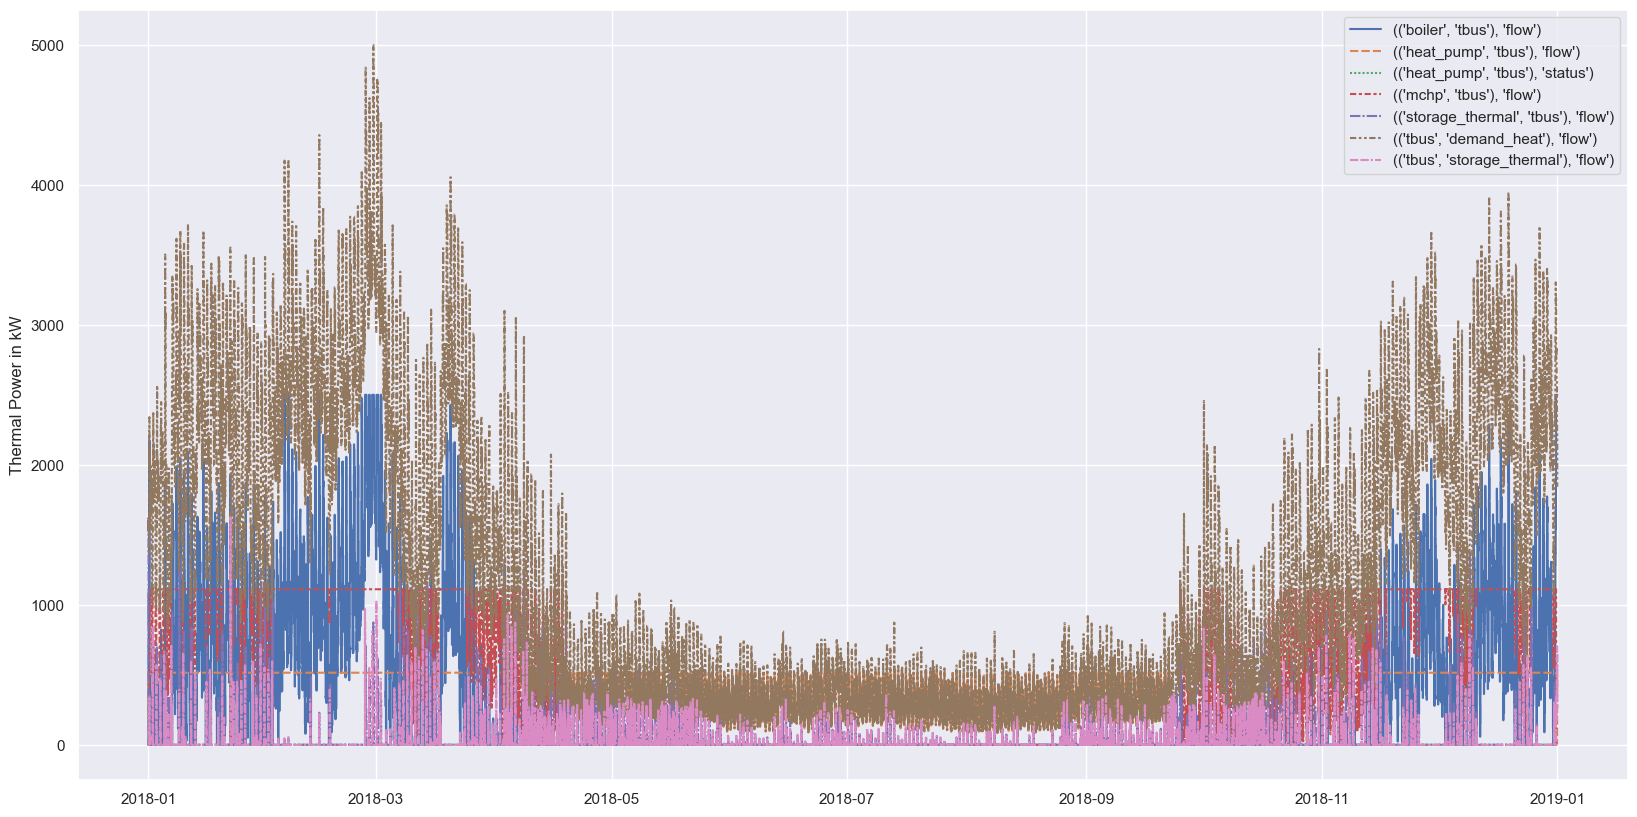

In [25]:
plt.figure(figsize=(20,10))
profiles = solph.processing.results(om)
res_bth = solph.views.node(profiles,'tbus')['sequences']
sns.set(style='darkgrid')
plot = sns.lineplot(data=res_bth, drawstyle='steps-post')
plot.set(ylabel='Thermal Power in kW')

### Ploting- thermal storage hourly status

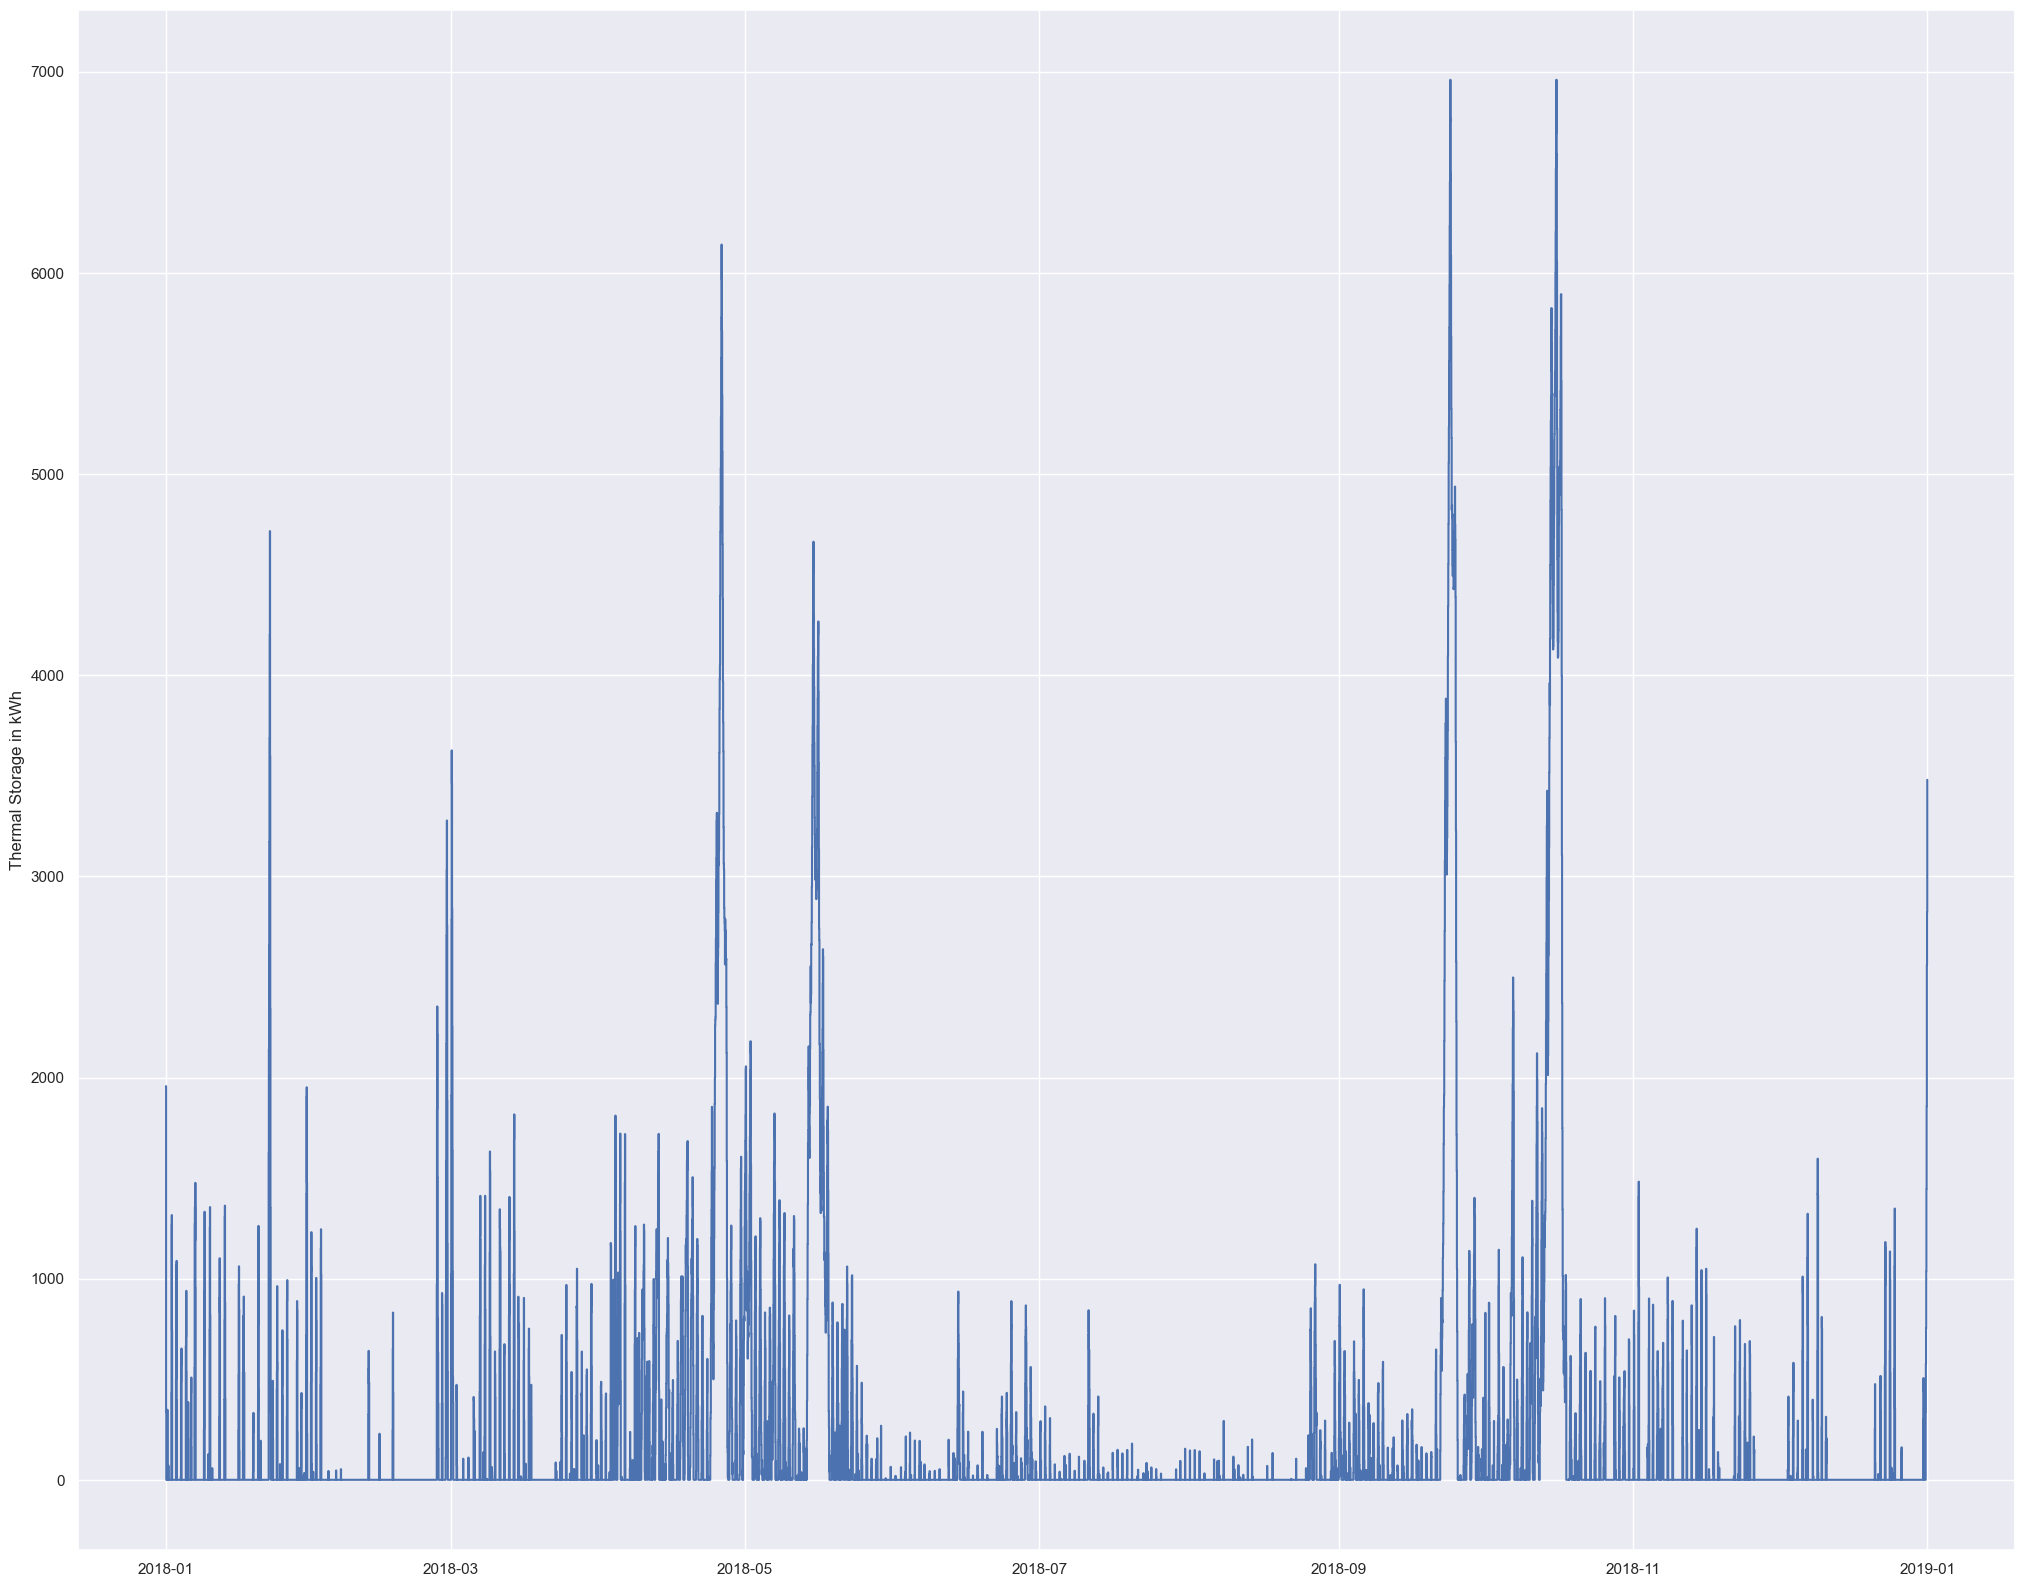

In [26]:
plt.figure(figsize=(25,20))
sns.set(style='darkgrid')
plot = sns.lineplot(data=pth_stor_res, drawstyle='steps-post')
plot.set(ylabel='Thermal Storage in kWh')
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

### Ploting- thermal load of HP

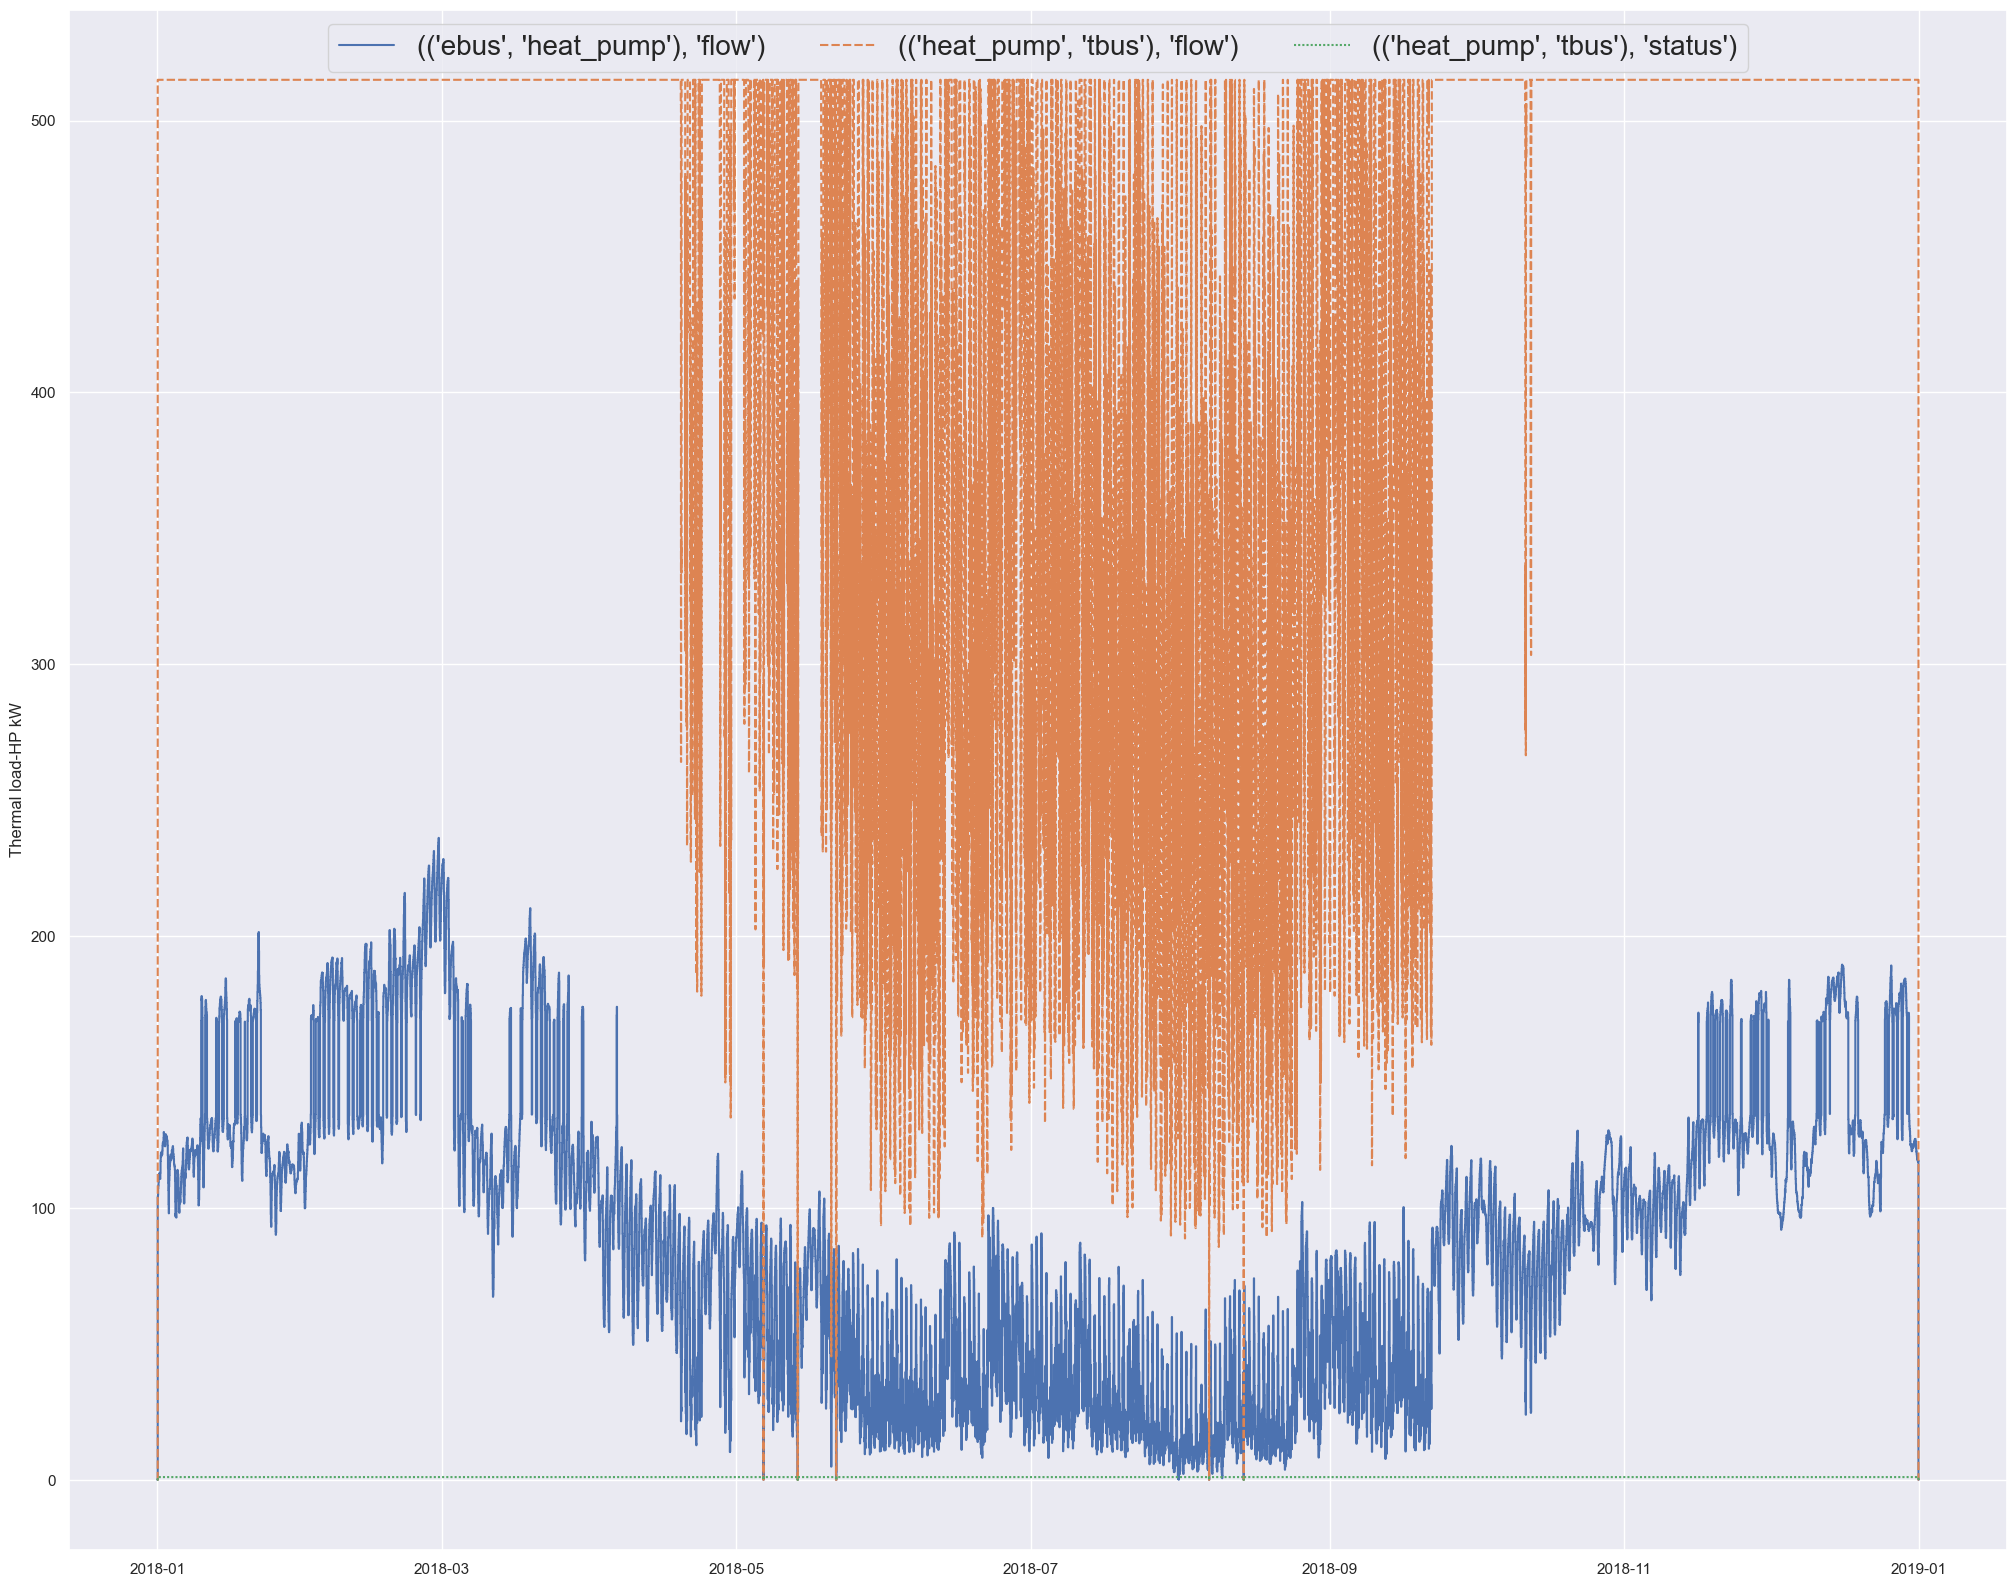

In [27]:
plt.figure(figsize=(25,20))
sns.set(style='darkgrid')
plot = sns.lineplot(data=res_hp, drawstyle='steps-post')
plot.set(ylabel='Thermal load-HP kW')
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
plot.legend(loc="upper center" ,prop={"size": 20}, ncol=3)

### Ploting- thermal load of CHP

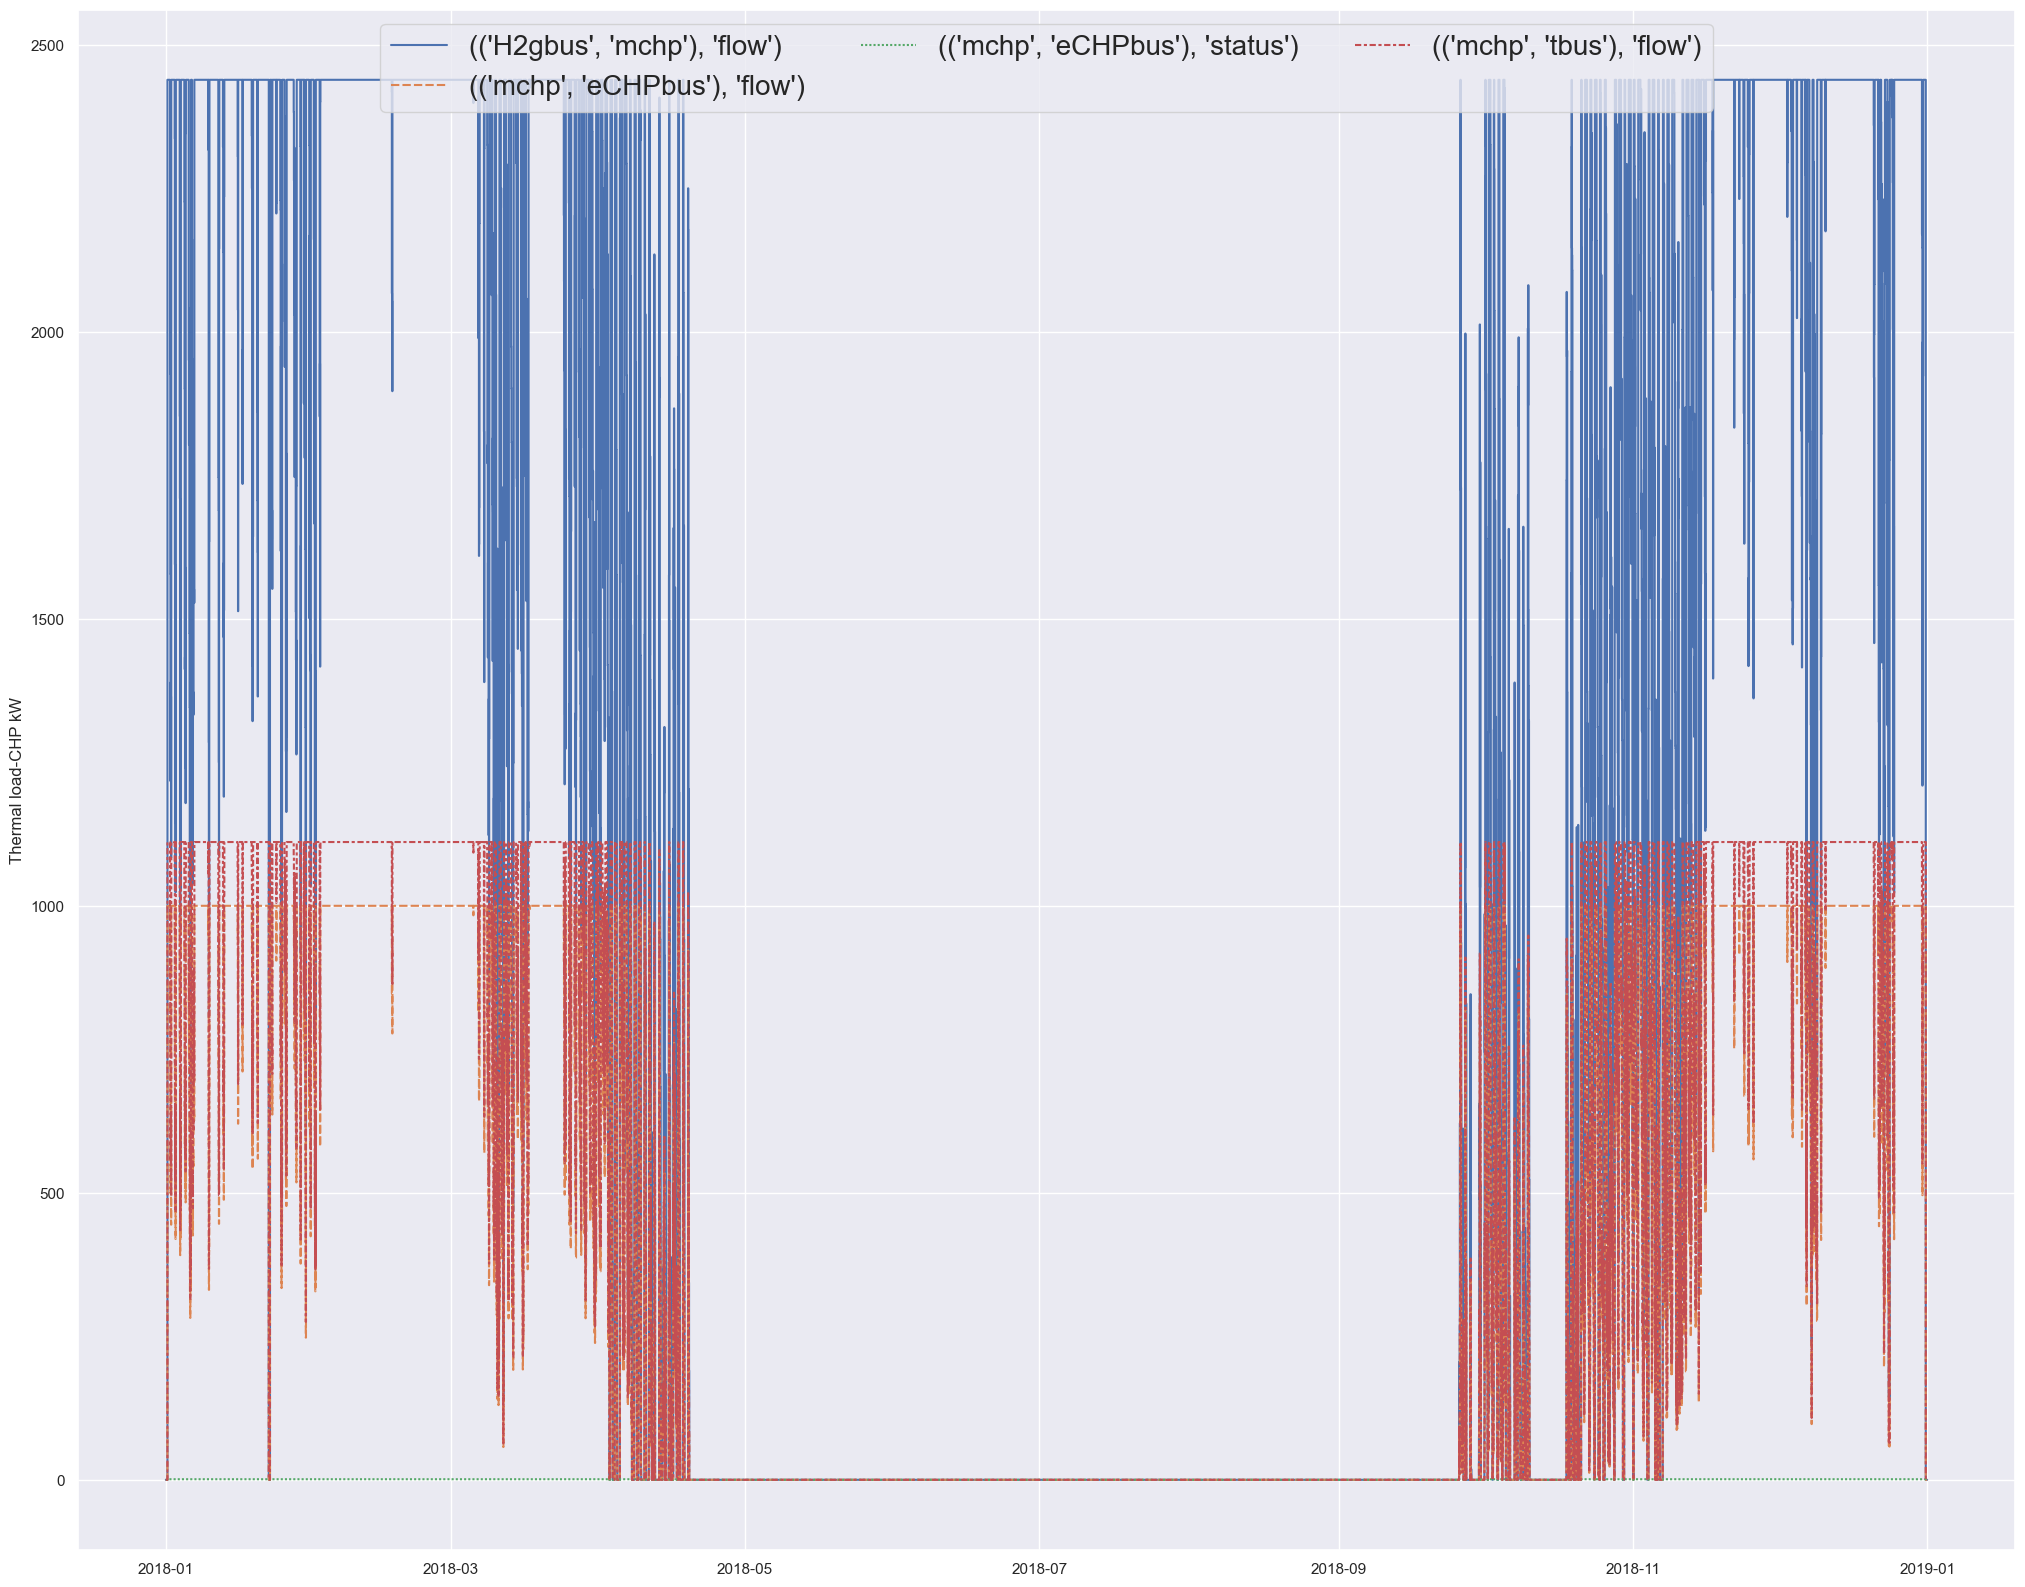

In [28]:
plt.figure(figsize=(25,20))
sns.set(style='darkgrid')
plot = sns.lineplot(data=res_chp, drawstyle='steps-post')
plot.set(ylabel='Thermal load-CHP kW')
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
plot.legend(loc="upper center" ,prop={"size": 20}, ncol=3)

### Ploting- thermal load of boiler

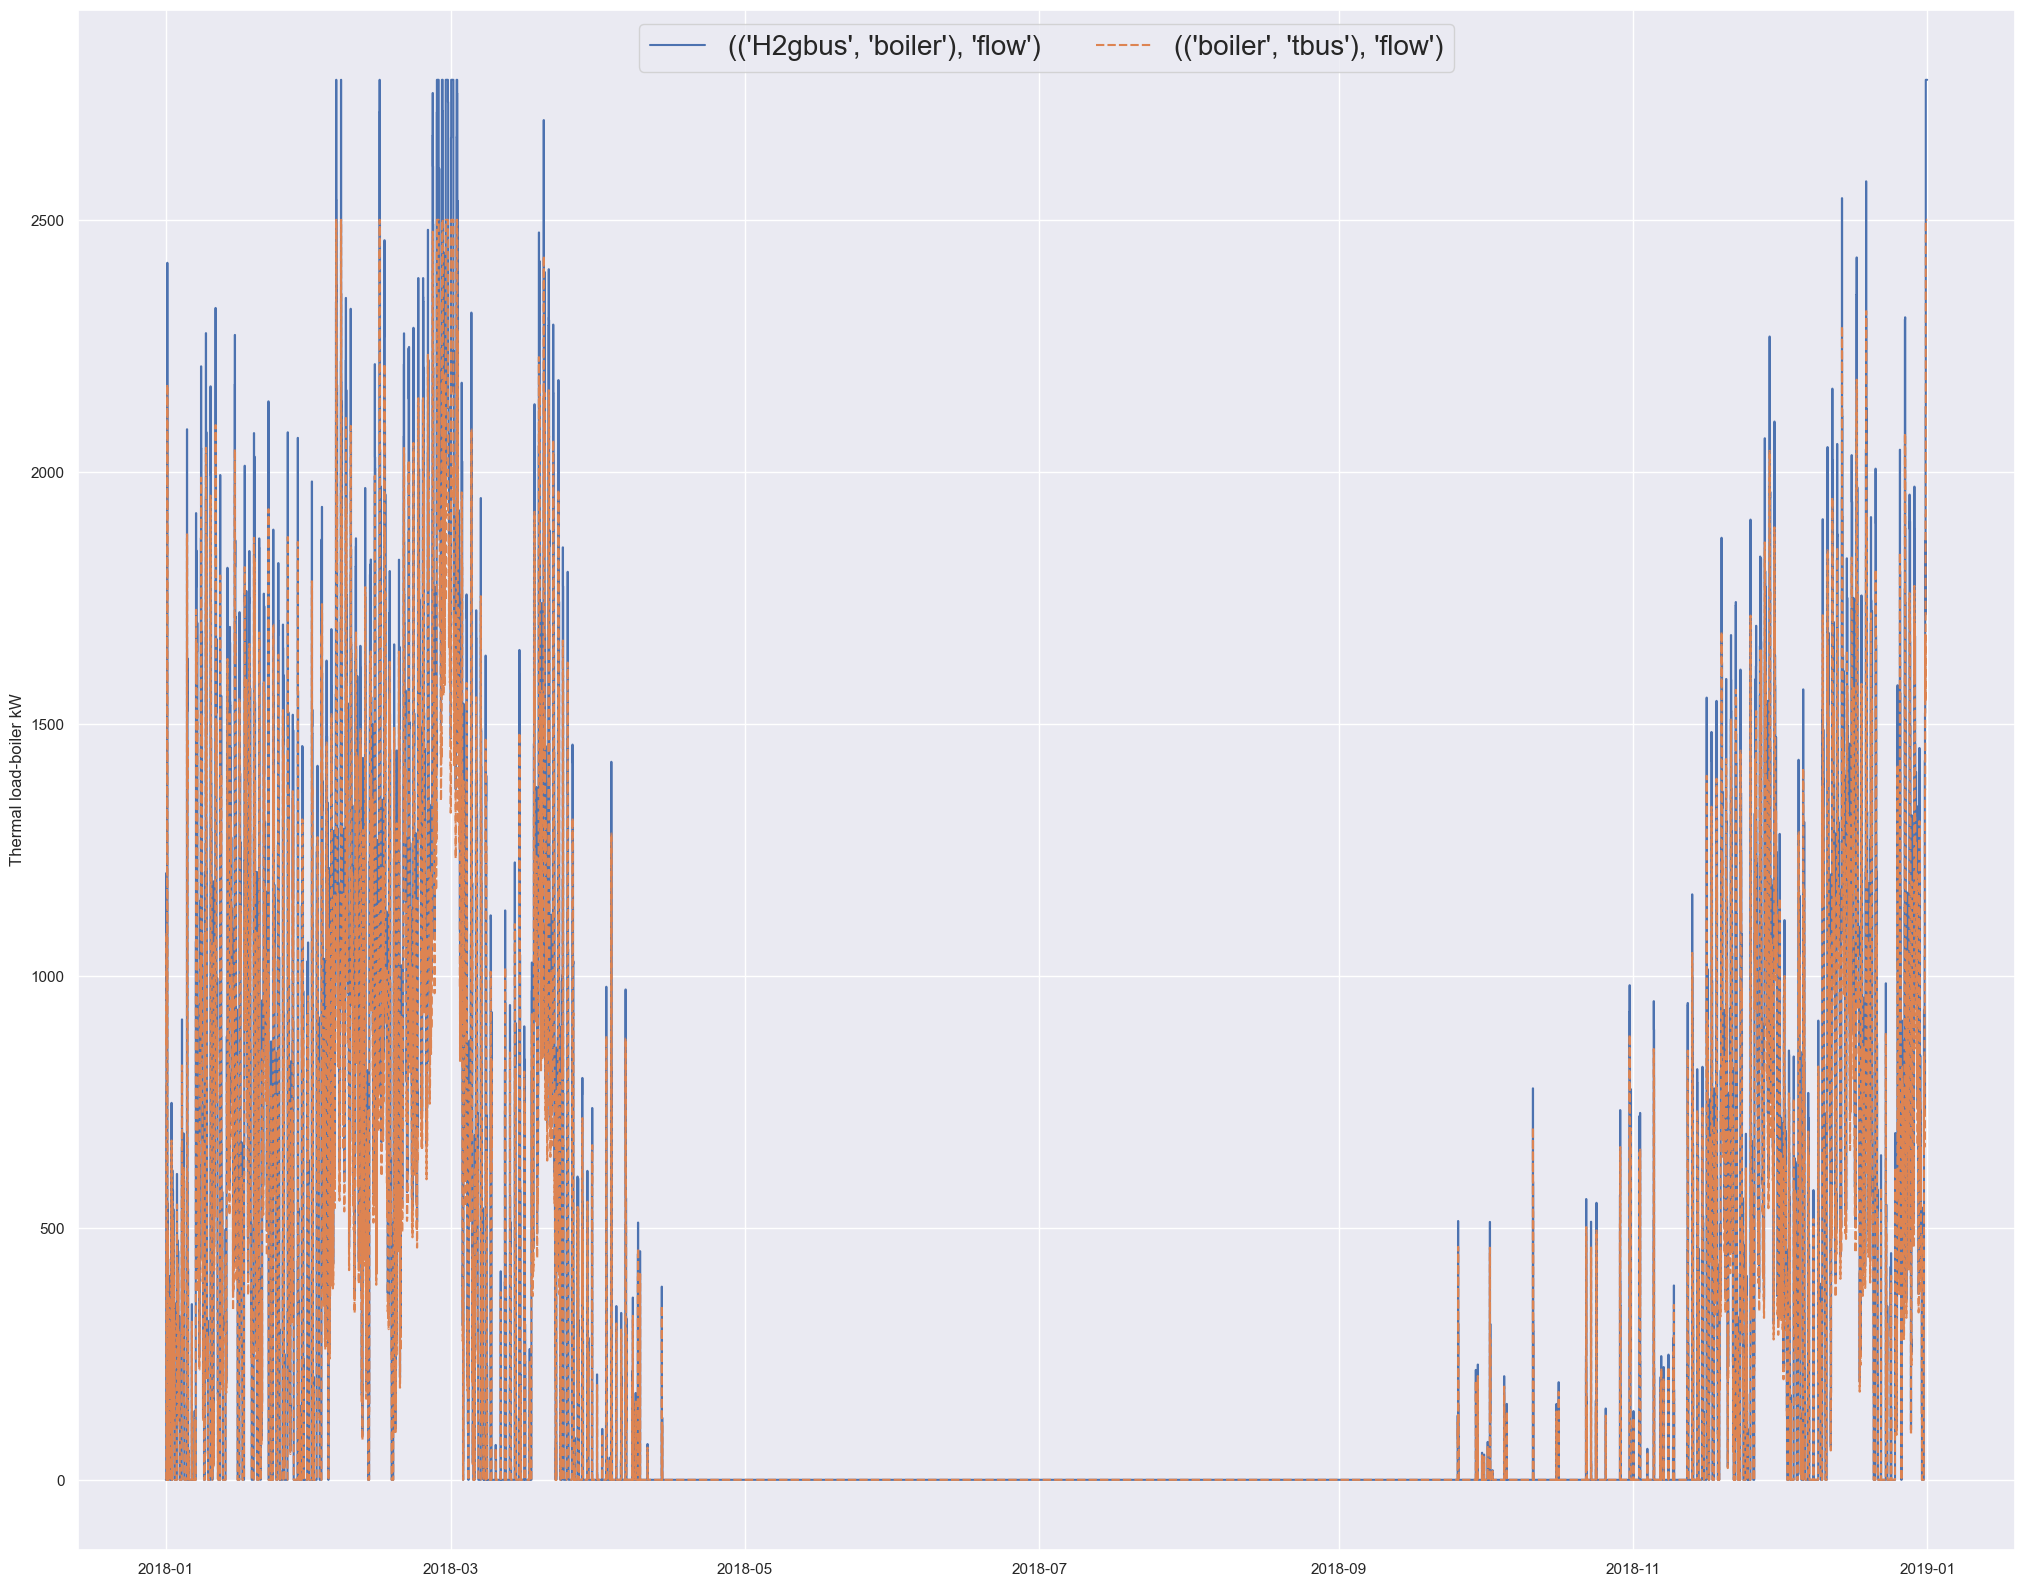

In [29]:
plt.figure(figsize=(25,20))
sns.set(style='darkgrid')
plot = sns.lineplot(data=res_blr, drawstyle='steps-post')
plot.set(ylabel='Thermal load-boiler kW')
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
plot.legend(loc="upper center" ,prop={"size": 20}, ncol=3)

### Ploting- temp. dep. cop

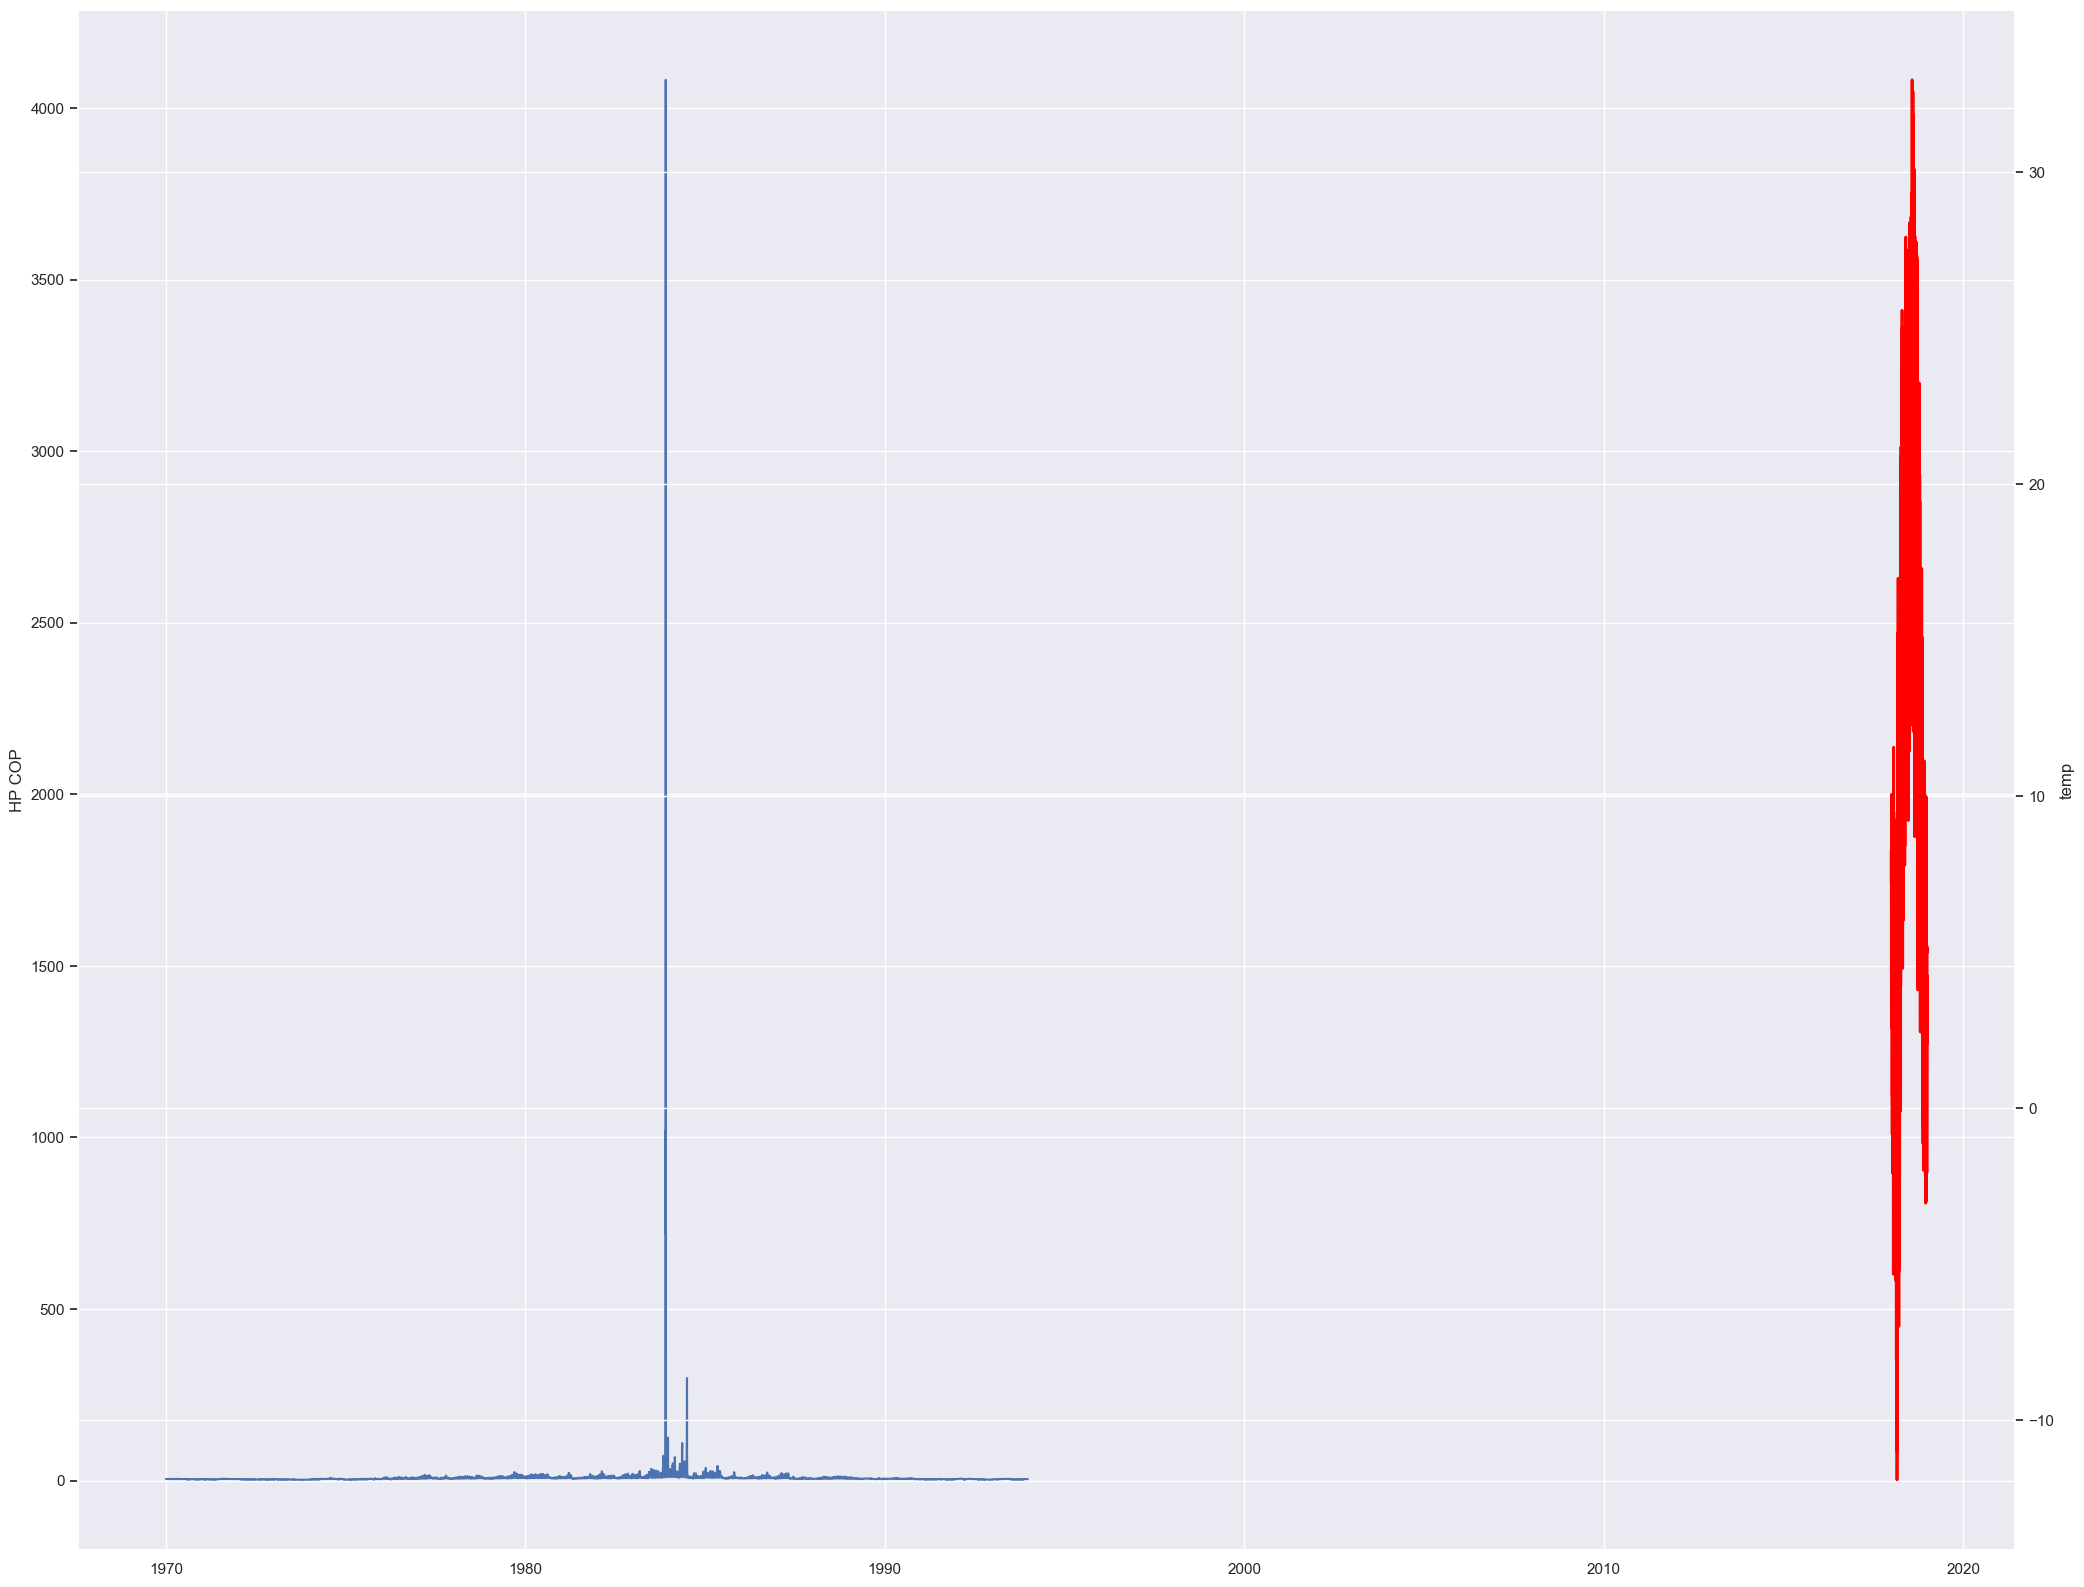

In [30]:
plt.figure(figsize=(25,20))
sns.set(style='darkgrid')
plot = sns.lineplot(data=cops_ASHP, drawstyle='steps-post')
plot.set(ylabel='HP COP')
ax2 = plt.twinx()
sns.lineplot(data=input_data.Temp, color="red", ax=ax2, linewidth=2)
ax2.set_ylabel("temp")
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)